In [2]:
import os
import s3fs
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from shapely import geometry

# Set up a local cluster for distributed computing.
from distributed import LocalCluster

from modules.utils import extract_time

In [3]:
cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 31.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51649,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:51689,Total threads: 4
Dashboard: http://127.0.0.1:51693/status,Memory: 5.32 GiB
Nanny: tcp://127.0.0.1:51652,


In [4]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefix = "tutorial_data/cpm_v253/"
prefix_url = "https://objects.eodc.eu"

# TODO: How would we get the data in another way? Where can we find the Zarr-data?
# Create the S3FileSystem with a custom endpoint
fs = s3fs.S3FileSystem(anon=True, client_kwargs={"endpoint_url": prefix_url})

# unregister handler to make boto3 work with CEPH
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
handler_to_unregister = handlers_to_unregister[0]
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handler_to_unregister
)

s3path = "s3://" + f"{bucket}/{prefix}" + "S2A_MSIL2A_*_*_*_T32UPC_*.zarr"

remote_files = fs.glob(s3path)

remote_product_path = prefix + remote_files[0]
paths = [f"{prefix_url}/{f}" for f in remote_files]
paths[:5]

['https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180601T102021_N0500_R065_T32UPC_20230902T045008.zarr',
 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180604T103021_N0500_R108_T32UPC_20230819T205634.zarr',
 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180611T102021_N0500_R065_T32UPC_20230714T225353.zarr',
 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180614T103021_N0500_R108_T32UPC_20230813T122609.zarr',
 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180621T102021_N0500_R065_T32UPC_20230827T073006.zarr']

In [5]:
%%time
r10m = xr.open_mfdataset(
    paths,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False,
)
r10m

CPU times: total: 4.27 s
Wall time: 28.6 s


<xarray.Dataset> Size: 105GB
Dimensions:  (time: 109, y: 10980, x: 10980)
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
Data variables:
    b02      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [6]:
%%time
r20m_mask_l2a_classification = xr.open_mfdataset(
    paths,
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False,
)
r20m_mask_l2a_classification

CPU times: total: 3.61 s
Wall time: 27.3 s


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 109, y: 5490, x: 5490)
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * y        (y) int64 44kB 5800010 5799990 5799970 ... 5690270 5690250 5690230
  * x        (x) int64 44kB 600010 600030 600050 600070 ... 709750 709770 709790
Data variables:
    scl      (time, y, x) uint8 3GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

In [7]:
# Define the resampling factor (10m to 100m = 10x)
factor = 2
r100m = r10m.coarsen(x=factor, y=factor, boundary="trim").mean()
r100m

<xarray.Dataset> Size: 105GB
Dimensions:  (time: 109, y: 5490, x: 5490)
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * y        (y) float64 44kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * x        (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
Data variables:
    b02      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b03      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b04      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b08      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

In [8]:
%%time
scl_100m = ( #Scene classification layer
    r20m_mask_l2a_classification.scl.chunk(chunks={"x": -1, "y": -1}).interp(
        x=r100m["x"], y=r100m["y"], method="nearest"
    )
    # Copy chunking from r10m['b02'] to cls_r10m
    .chunk(r100m["b02"].chunks)
)
scl_100m

CPU times: total: 156 ms
Wall time: 223 ms


<timed exec>:6: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.


<xarray.DataArray 'scl' (time: 109, y: 5490, x: 5490)> Size: 26GB
dask.array<rechunk-merge, shape=(109, 5490, 5490), dtype=float64, chunksize=(1, 915, 915), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * y        (y) float64 44kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * x        (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
Attributes:
    _eopf_attrs:     {'coordinates': ['x', 'y'], 'dimensions': ['y', 'x']}
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    proj:epsg:       32632
    proj:shape:      [5490, 5490]
    proj:transform:  [20.0, 0.0, 600000.0, 0.0, -20.0, 5800020.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...

In [9]:
from modules.utils import validate_scl

valid_mask = validate_scl(scl_100m)  # Boolean mask (10980x10980)
valid_mask

<xarray.DataArray 'scl' (time: 109, y: 5490, x: 5490)> Size: 3GB
dask.array<invert, shape=(109, 5490, 5490), dtype=bool, chunksize=(1, 915, 915), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * y        (y) float64 44kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * x        (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05

In [10]:
valid_r100m = r100m.where(valid_mask)
valid_r100m

<xarray.Dataset> Size: 105GB
Dimensions:  (time: 109, y: 5490, x: 5490)
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * y        (y) float64 44kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * x        (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
Data variables:
    b02      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b03      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b04      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b08      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

In [11]:
scale = valid_r100m["b04"].attrs["_eopf_attrs"]["scale_factor"]
offset = valid_r100m["b08"].attrs["_eopf_attrs"]["add_offset"]
reflectances_r100m = (valid_r100m * scale) + offset

In [12]:
b08 = reflectances_r100m["b08"]
b04 = reflectances_r100m["b04"]
ndvi = (b08 - b04) / (b08 + b04)  # Per-pixel NDVI
reflectances_r100m["ndvi"] = ndvi
reflectances_r100m

<xarray.Dataset> Size: 131GB
Dimensions:  (x: 5490, y: 5490, time: 109)
Coordinates:
  * x        (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y        (y) float64 44kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b03      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b04      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b08      (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    ndvi     (time, y, x) float64 26GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

In [13]:
polygon = gpd.read_file("resources/Nationalpark_Harz_boundaries.geojson")
polygon.explore()

In [14]:
epsg = 32632

bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
bbox_reproj

(591193.8903990765, 5725096.170123739, 613373.5668988454, 5751222.874423799)

In [15]:
cloudless_bands_ndvi = reflectances_r100m.sel(
    time=datetime(2018, 6, 4), method="nearest"
)

x_slice = slice(bbox_reproj[0], bbox_reproj[2])  # ~100 pixels
y_slice = slice(bbox_reproj[3], bbox_reproj[1])  # ~100 pixels

region = cloudless_bands_ndvi.sel(x=x_slice, y=y_slice).chunk(
    {"y": "auto", "x": "auto"}
)
region

<xarray.Dataset> Size: 35MB
Dimensions:  (x: 669, y: 1306)
Coordinates:
  * x        (x) float64 5kB 6e+05 6e+05 6e+05 ... 6.133e+05 6.134e+05 6.134e+05
  * y        (y) float64 10kB 5.751e+06 5.751e+06 ... 5.725e+06 5.725e+06
    time     datetime64[ns] 8B 2018-06-04T10:30:21
Data variables:
    b02      (y, x) float64 7MB dask.array<chunksize=(1306, 669), meta=np.ndarray>
    b03      (y, x) float64 7MB dask.array<chunksize=(1306, 669), meta=np.ndarray>
    b04      (y, x) float64 7MB dask.array<chunksize=(1306, 669), meta=np.ndarray>
    b08      (y, x) float64 7MB dask.array<chunksize=(1306, 669), meta=np.ndarray>
    ndvi     (y, x) float64 7MB dask.array<chunksize=(1306, 669), meta=np.ndarray>

In [16]:
%%time
rgb = region[["b04", "b03", "b02"]].to_dataarray(dim="bands")
rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
rgb = rgb.clip(0, 1).compute()
ndvi = region["ndvi"].compute()

CPU times: total: 2 s
Wall time: 7.45 s


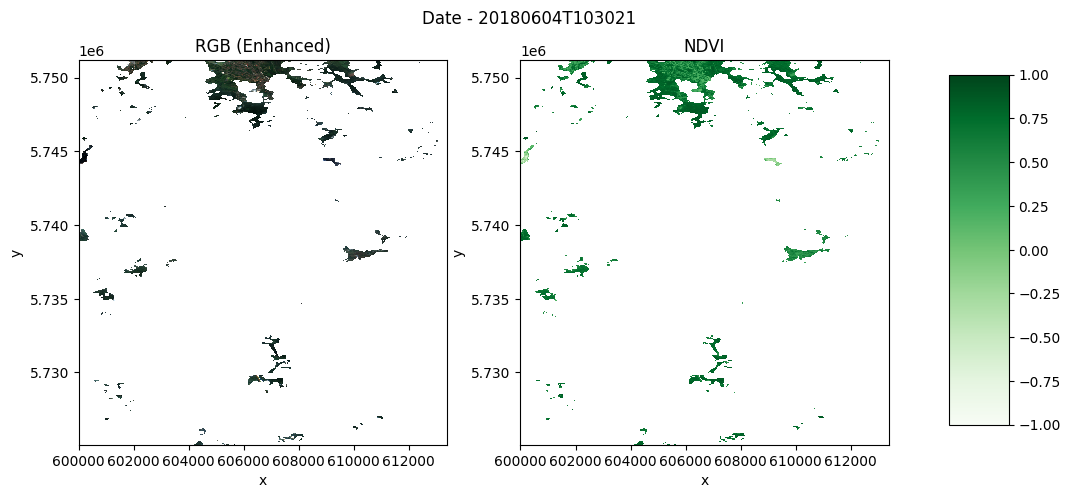

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Date - 20180604T103021\n")

# First subplot
rgb.plot.imshow(
    ax=ax1,
    rgb="bands",
    extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
)

ax1.set_title("RGB (Enhanced)")

# Second plot
ndvi_plot = ndvi.plot(ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False)
ax2.set_title("NDVI")

# Add color bar on the right
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ndvi_plot, cax=cbar_ax)

In [18]:
# Group by year and compute mean
yearly_ds = (
    reflectances_r100m.sel(x=x_slice, y=y_slice)
    .groupby("time.year")
    .mean(dim="time", skipna=True)
)
yearly_ds

<xarray.Dataset> Size: 210MB
Dimensions:  (year: 6, y: 1306, x: 669)
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
  * y        (y) float64 10kB 5.751e+06 5.751e+06 ... 5.725e+06 5.725e+06
  * x        (x) float64 5kB 6e+05 6e+05 6e+05 ... 6.133e+05 6.134e+05 6.134e+05
Data variables:
    b02      (year, y, x) float64 42MB dask.array<chunksize=(1, 305, 669), meta=np.ndarray>
    b03      (year, y, x) float64 42MB dask.array<chunksize=(1, 305, 669), meta=np.ndarray>
    b04      (year, y, x) float64 42MB dask.array<chunksize=(1, 305, 669), meta=np.ndarray>
    b08      (year, y, x) float64 42MB dask.array<chunksize=(1, 305, 669), meta=np.ndarray>
    ndvi     (year, y, x) float64 42MB dask.array<chunksize=(1, 305, 669), meta=np.ndarray>

In [19]:
def plot_rgb_ndvi(dset, year, x_slice, y_slice):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Date - " + str(year) + "\n")

    # First subplot
    rgb = dset[["b04", "b03", "b02"]].to_dataarray(dim="bands")
    rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
    rgb = rgb.clip(0, 1)  # Clip to valid range
    rgb.plot.imshow(
        ax=ax1,
        rgb="bands",
        extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
    )
    ax1.set_title("RGB (Enhanced)")

    # Second plot
    ndvi_plot = dset["ndvi"].plot(
        ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False
    )
    ax2.set_title("NDVI")

    # Add color bar on the right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ndvi_plot, cax=cbar_ax)

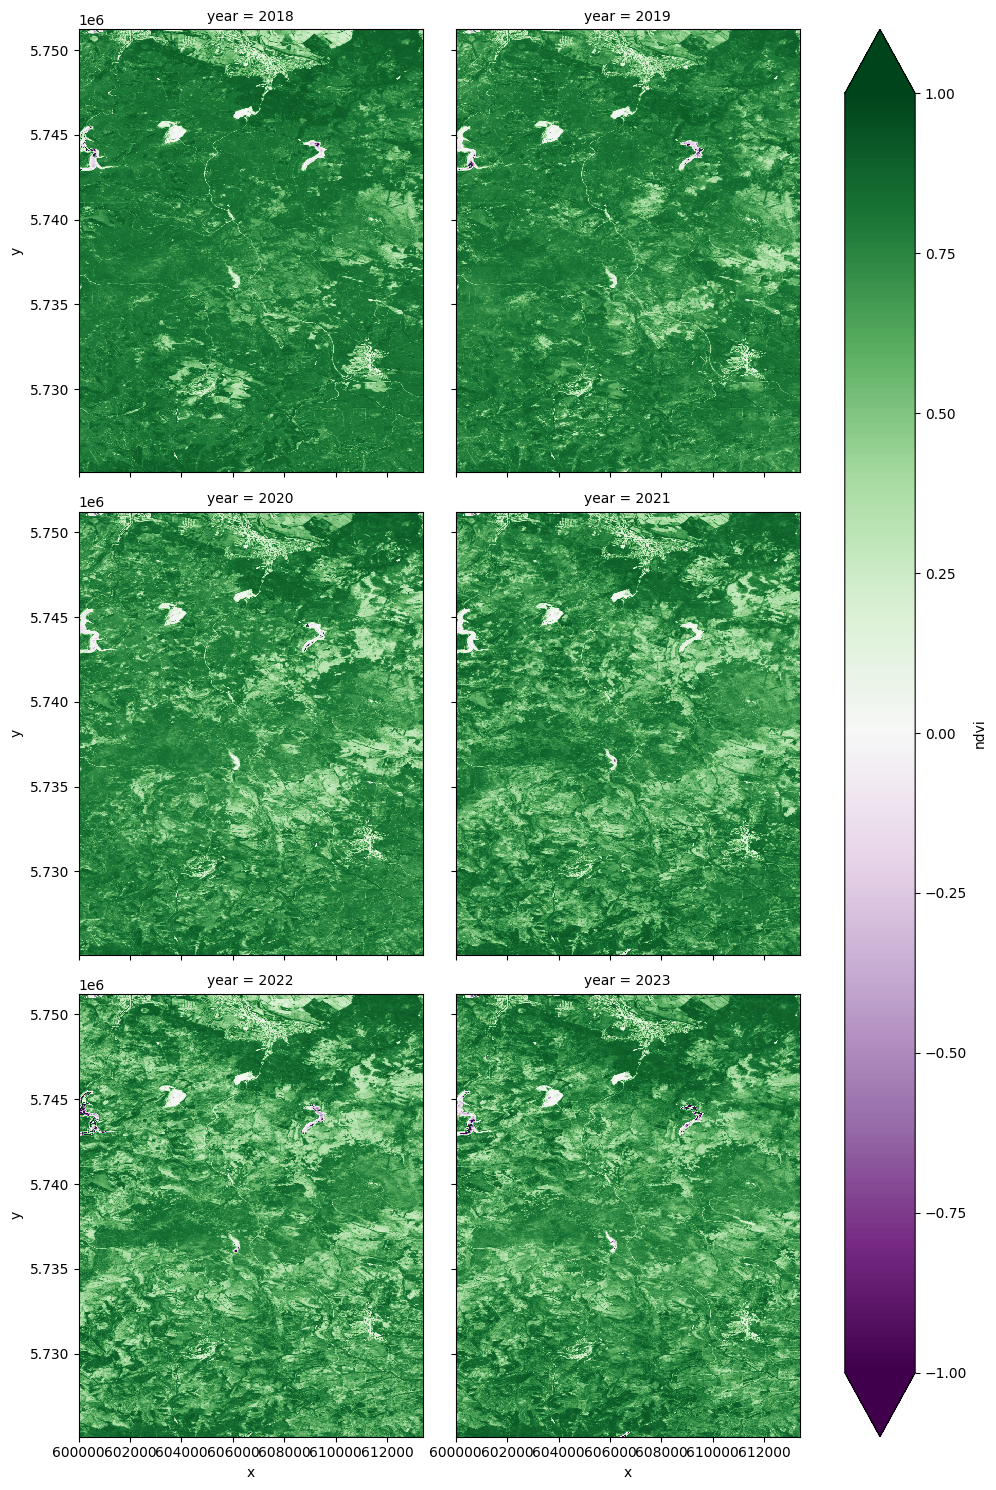

In [20]:
ndvi_yearly = yearly_ds["ndvi"].sel(x=x_slice, y=y_slice).sel(year=slice(2018, 2025))

ndvi_yearly.plot(
    cmap="PRGn", x="x", y="y", col="year", col_wrap=2, vmin=-1, vmax=1, figsize=(10, 15)
)

In [21]:
%%time
encoding = {}
for var in region.data_vars:
    encoding[var] = {"dtype": "float32"}
region.to_zarr("data_region.zarr", zarr_format=2, encoding=encoding, mode="w")

<timed exec>:4: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
<timed exec>:4: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs


CPU times: total: 1.8 s
Wall time: 4.23 s


In [22]:
from modules.utils import to_km2

yearly_ds["FOREST"] = yearly_ds.ndvi > 0.7

resolution = (100, 100)
forest_pixels = yearly_ds.sel(x=x_slice, y=y_slice).FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
dask.array<truediv, shape=(6,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

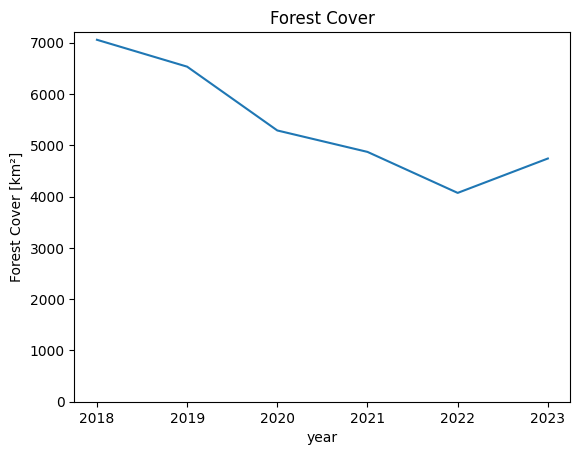

In [23]:
forest_area_km2.plot()

plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

In [24]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

In [25]:
plot_year = 2022
yearly_ds["CHANGE"] = yearly_ds.FOREST.astype(int).diff("year", label="upper")
yearly_ds["CHANGE"].compute()

<xarray.DataArray 'CHANGE' (year: 6, y: 1306, x: 669)> Size: 42MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., -1., -1.,  0.],
        [ 0.,  0.,  0., ..., -1.,  0.,  0.],
        [ 0.,  0.,  0., ..., -1., -1.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0., -1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [-1.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., -1., -1.],
        [ 0.,  0.,  0., ...,  0.,  0., -1.]],

       [[ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., -1.,  0.]]], shape=(6, 1306, 669))
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
  * y        (y) float64 10kB 5.751e+06 5.751e+06 ... 5.725e+06 5.725e+06
  * x        (x) float64 5kB 6e+05 6e+05 6e+05 ... 6.133e+05 6.134e+05 6.134e+05

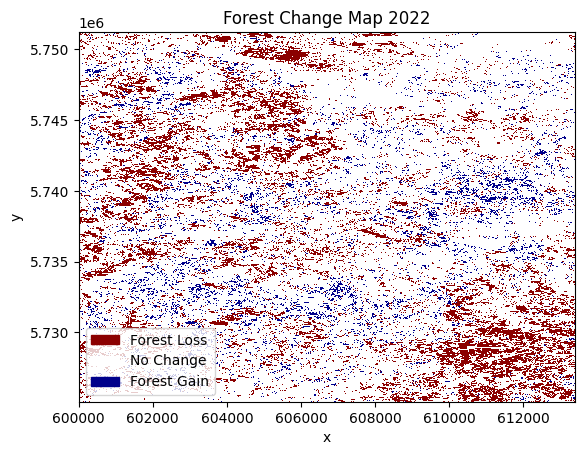

In [26]:
yearly_ds.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)
# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}");

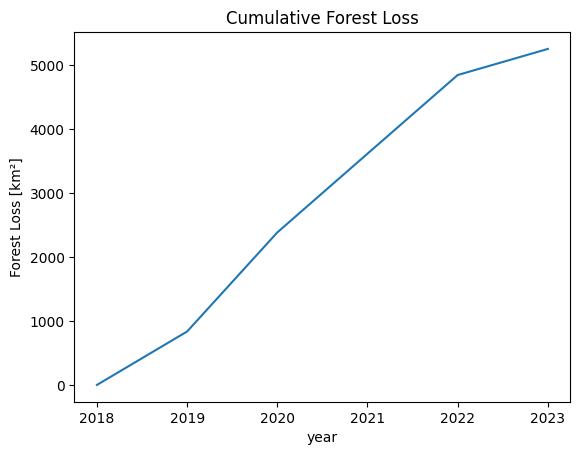

In [27]:
# Forest Loss per Year
forest_loss = (yearly_ds.CHANGE == -1).sum(["x", "y"])
forest_loss_km2 = to_km2(forest_loss, resolution)
forest_loss_km2.cumsum().plot()
plt.title("Cumulative Forest Loss")
plt.ylabel("Forest Loss [km²]");

In [28]:
data_path = Path("./data/")
data_path.mkdir(parents=True, exist_ok=True)
hansen_filename = "Hansen_GFC-2022-v1.10_lossyear_60N_010E.tif"
comp_data = data_path / hansen_filename

with comp_data.open("wb") as fs:
    hansen_data = requests.get(
        f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/{hansen_filename}"
    )
    fs.write(hansen_data.content)

In [29]:
import matplotlib.pyplot as plt
import rioxarray

target_epsg = epsg
# Open the file (replace 'comp_data' with your raster file path)
ground_truth = (
    rioxarray.open_rasterio(comp_data)  # Replace with your file path
    .rio.clip_box(
        minx=bbox_reproj[0],
        miny=bbox_reproj[1],
        maxx=bbox_reproj[2],
        maxy=bbox_reproj[3],
    )
    .rio.reproject(target_epsg)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)  # Fill no-data (values > 100) with 0
)

# Plot
ground_truth.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data")
plt.show()

NoDataInBounds: No data found in bounds.

In [ ]:
yearly_ds["GROUND_TRUTH"] = ground_truth.interp_like(
    yearly_ds, method="nearest"
).astype(int)
yearly_ds

In [ ]:
# convert lost forest (-1) into the year it was lost
lost_year = (yearly_ds.CHANGE == -1) * yearly_ds.year % 100
first_nonzero = (lost_year != 0).argmax(axis=0).compute()
yearly_ds["LOST_YEAR"] = lost_year[first_nonzero]
yearly_ds.LOST_YEAR.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Classification Forest Loss Year");

In [ ]:
yearly_ds.GROUND_TRUTH.plot(
    levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"}, cmap="viridis"
)
plt.title("Global Forest Watch - Interpolated");

In [ ]:
from sklearn.metrics import accuracy_score

score = accuracy_score(
    (yearly_ds.LOST_YEAR > 18).values.ravel(),
    (yearly_ds.GROUND_TRUTH > 18).values.ravel(),
)
print(f"The overall accuracy of forest loss detection is {score:.2f}.")